In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.mechanics import dynamicsymbols, init_vprinting, msubs
from tqdm import tqdm

%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

init_printing()
init_vprinting()

#theta, theta1, theta2, theta3, theta4, theta5 = symbols('theta theta_1 theta_2 theta_3 theta_4 theta_5', cls=Function)
theta, theta2, theta3, theta4, theta5 = symbols('theta theta_2 theta_3 theta_4 theta_5', cls=Function)

theta_x, theta_y, theta_z, x_d, y_d, z_d, t = symbols('theta_x theta_y theta_z x_d y_d z_d, t')

#theta1_dot, theta2_dot, theta3_dot, theta4_dot, theta5_dot = symbols('thetadot1 thetadot2 thetadot3 thetadot4 thetadot5', cls=Function)
theta2_dot, theta3_dot, theta4_dot, theta5_dot = symbols('thetadot2 thetadot3 thetadot4 thetadot5', cls=Function)

In [2]:
#Base frame is the same as hip axis 3, only hip axis 3 rotates around Z axis.

#IMPORTANT: signs for l could be swapped here, so either exclude them and adjust later when substituting
#           or change below.

#l1_x, l2_x, l3_x, l4_x, l5_x, l6_x = symbols('l1_x l2_x l3_x l4_x l5_x l6_x')
#l1_y, l2_y, l3_y, l4_y, l5_y, l6_y = symbols('l1_y l2_y l3_y l4_y l5_y l6_y')
#l1_z, l2_z, l3_z, l4_z, l5_z, l6_z = symbols('l1_z l2_z l3_z l4_z l5_z l6_z')
l2_x, l3_x, l4_x, l5_x, l6_x = symbols('l2_x l3_x l4_x l5_x l6_x')
l2_y, l3_y, l4_y, l5_y, l6_y = symbols('l2_y l3_y l4_y l5_y l6_y')
l2_z, l3_z, l4_z, l5_z, l6_z = symbols('l2_z l3_z l4_z l5_z l6_z')

#l1_z: From base to hip 3 = 0. Removed in this version since it seems to mess up MPC with torques
#l2_z: From hip 3 to hip 2 = 0.145
#l3_z: From hip 2 to hip 1 = 0.145
#l4_z: From hip 1 to knee = 0.41
#l5_z: From Knee to ankle = 0.375
#l6_z: From ankle joint to foot base = 0.04co

#Transformation from Base frame to Hip axis 3

#H01_simple = Matrix([[cos(theta1(t)), -sin(theta1(t)), 0, -l1_x],
#                     [sin(theta1(t)), cos(theta1(t)), 0, -l1_y],
#                     [0, 0, 1, -l1_z], #l1_z should be 0 here because base frame is in Hip axis 3 frame, just with no rotation
#                     [0, 0, 0, 1]])

#Transformation from Base frame to to Hip axis 2

H02_simple = Matrix([[cos(theta2(t)), 0, sin(theta2(t)), -l2_x],
                     [0, 1, 0, -l2_y],
                     [-sin(theta2(t)), 0, cos(theta2(t)), -l2_z],
                     [0, 0, 0, 1]])

#Transformation from Hip axis 2 to Hip axis 1

H23_simple = Matrix([[1, 0, 0, -l3_x],
                     [0, cos(theta3(t)), -sin(theta3(t)), -l3_y],
                     [0, sin(theta3(t)), cos(theta3(t)), -l3_z],
                     [0, 0, 0, 1]])

#Transformation from Hip axis 1 to Knee

H34_simple = Matrix([[1, 0, 0, -l4_x],
                     [0, cos(theta4(t)), -sin(theta4(t)), -l4_y],
                     [0, sin(theta4(t)), cos(theta4(t)), -l4_z],
                     [0, 0, 0, 1]])

#Tranformation from Knee to Ankle

H45_simple = Matrix([[1, 0, 0, -l5_x],
                     [0, cos(theta5(t)), -sin(theta5(t)), -l5_y],
                     [0, sin(theta5(t)), cos(theta5(t)), -l5_z],
                     [0, 0, 0, 1]])

#H02_simple = H01_simple * H12_simple
H03_simple = H02_simple * H23_simple
H04_simple = H03_simple * H34_simple

H05_simple = H04_simple * H45_simple
print("Simplified H05:")
simplify(H05_simple)

Simplified H05:


⎡cos(θ₂)   sin(θ₃ + θ₄ + θ₅)⋅sin(θ₂)  sin(θ₂)⋅cos(θ₃ + θ₄ + θ₅)  -l₂ ₓ - l₃ ₓ⋅
⎢                                                                             
⎢   0          cos(θ₃ + θ₄ + θ₅)         -sin(θ₃ + θ₄ + θ₅)                   
⎢                                                                             
⎢-sin(θ₂)  sin(θ₃ + θ₄ + θ₅)⋅cos(θ₂)  cos(θ₃ + θ₄ + θ₅)⋅cos(θ₂)  -l_2_z + l₃ ₓ
⎢                                                                             
⎣   0                  0                          0                           

cos(θ₂) - l_3_z⋅sin(θ₂) - l₄ ₓ⋅cos(θ₂) - l_4_y⋅sin(θ₂)⋅sin(θ₃) - l_4_z⋅sin(θ₂)
                                                                              
                             -l_2_y - l_3_y - l_4_y⋅cos(θ₃) + l_4_z⋅sin(θ₃) - 
                                                                              
⋅sin(θ₂) - l_3_z⋅cos(θ₂) + l₄ ₓ⋅sin(θ₂) - l_4_y⋅sin(θ₃)⋅cos(θ₂) - l_4_z⋅cos(θ₂
                                                   

In [3]:
#Distance from previous frame to next frame. Frames are placed at CoM in this scenario.
#l1_com, l2_com, l3_com, l4_com, l5_com, l6_com = symbols("l1_{CoM} l2_{CoM} l3_{CoM} l4_{CoM} l5_{CoM} l6_{CoM}")

#l1_x_com, l2_x_com, l3_x_com, l4_x_com, l5_x_com, l6_x_com = symbols('l1_x_com l2_x_com l3_x_com l4_x_com l5_x_com l6_x_com')
#l1_y_com, l2_y_com, l3_y_com, l4_y_com, l5_y_com, l6_y_com = symbols('l1_y_com l2_y_com l3_y_com l4_y_com l5_y_com l6_y_com')
#l1_z_com, l2_z_com, l3_z_com, l4_z_com, l5_z_com, l6_z_com = symbols('l1_z_com l2_z_com l3_z_com l4_z_com l5_z_com l6_z_com')
l2_x_com, l3_x_com, l4_x_com, l5_x_com, l6_x_com = symbols('l2_x_com l3_x_com l4_x_com l5_x_com l6_x_com')
l2_y_com, l3_y_com, l4_y_com, l5_y_com, l6_y_com = symbols('l2_y_com l3_y_com l4_y_com l5_y_com l6_y_com')
l2_z_com, l3_z_com, l4_z_com, l5_z_com, l6_z_com = symbols('l2_z_com l3_z_com l4_z_com l5_z_com l6_z_com')

#H01_com = Matrix([[1, 0, 0, -l1_x_com],
#                  [0, 1, 0, -l1_y_com],
#                  [0, 0, 1, -l1_z_com],
#                  [0, 0, 0, 1]])

H02_com = Matrix([[1, 0, 0, -l2_x_com],
                  [0, 1, 0, -l2_y_com],
                  [0, 0, 1, -l2_z_com],
                  [0, 0, 0, 1]])

H23_com = Matrix([[1, 0, 0, -l3_x_com],
                  [0, 1, 0, -l3_y_com],
                  [0, 0, 1, -l3_z_com],
                  [0, 0, 0, 1]])

H34_com = Matrix([[1, 0, 0, -l4_x_com],
                  [0, 1, 0, -l4_y_com],
                  [0, 0, 1, -l4_z_com],
                  [0, 0, 0, 1]])

H45_com = Matrix([[1, 0, 0, -l5_x_com],
                  [0, 1, 0, -l5_y_com],
                  [0, 0, 1, -l5_z_com],
                  [0, 0, 0, 1]])

#H02_com = H01_simple * H12_com
H03_com = H02_simple * H23_com
H04_com = H03_simple * H34_com
H05_com = H04_simple * H45_com

print("Simplified H05_com:")
simplify(H05_com)

Simplified H05_com:


⎡cos(θ₂)   sin(θ₃ + θ₄)⋅sin(θ₂)  sin(θ₂)⋅cos(θ₃ + θ₄)  -l₂ ₓ - l₃ ₓ⋅cos(θ₂) - 
⎢                                                                             
⎢   0          cos(θ₃ + θ₄)         -sin(θ₃ + θ₄)                             
⎢                                                                             
⎢-sin(θ₂)  sin(θ₃ + θ₄)⋅cos(θ₂)  cos(θ₃ + θ₄)⋅cos(θ₂)  -l_2_z + l₃ ₓ⋅sin(θ₂) -
⎢                                                                             
⎣   0               0                     0                                   

l_3_z⋅sin(θ₂) - l₄ ₓ⋅cos(θ₂) - l_4_y⋅sin(θ₂)⋅sin(θ₃) - l_4_z⋅sin(θ₂)⋅cos(θ₃) -
                                                                              
                      -l_2_y - l_3_y - l_4_y⋅cos(θ₃) + l_4_z⋅sin(θ₃) - l_5_y_c
                                                                              
 l_3_z⋅cos(θ₂) + l₄ ₓ⋅sin(θ₂) - l_4_y⋅sin(θ₃)⋅cos(θ₂) - l_4_z⋅cos(θ₂)⋅cos(θ₃) 
                                                   

In [4]:
# The position vectors are merely the Z displacement as the frames get rotated by the joints directly.
# This requires a "p" vector for every position.

p_com_foot = Matrix([-l6_x_com, -l6_y_com, -l6_z_com, 1])
p_foot = Matrix([-l6_x, -l6_y, -l6_z, 1])

p = Matrix([0, 0, 0, 1])

# To get velocities, *always* use x_dot = J * q_dot , where J is the Jacobian for the link!

#hip_axis_3_com_pos = simplify(H01_com * p)

hip_axis_2_com_pos = simplify(H02_com * p)

hip_axis_1_com_pos = simplify(H03_com * p)

upper_leg_com_pos = simplify(H04_com * p)

lower_leg_com_pos = simplify(H05_com * p)

foot_com_pos = simplify(H05_simple * p_com_foot)

In [5]:
#foot_com_pos.subs({theta1(t):0, theta2(t):0, theta3(t):0, theta4(t):pi/2, theta5(t):0})
foot_com_pos.subs({theta2(t):0, theta3(t):0, theta4(t):pi/2, theta5(t):0})

⎡  -l₂ ₓ - l₃ ₓ - l₄ ₓ - l₅ ₓ - l_6_x_com  ⎤
⎢                                          ⎥
⎢-l_2_y - l_3_y - l_4_y + l_5_z + l_6_z_com⎥
⎢                                          ⎥
⎢-l_2_z - l_3_z - l_4_z - l_5_y - l_6_y_com⎥
⎢                                          ⎥
⎣                    1                     ⎦

In [6]:
#m_hip_axis_3, m_hip_axis_2, m_hip_axis_1, m_upper_leg, m_lower_leg, m_foot = symbols('m_{hip3} m_{hip2} m_{hip1} m_{ul} m_{ll} m_{foot}')
m_hip_axis_2, m_hip_axis_1, m_upper_leg, m_lower_leg, m_foot = symbols('m_{hip2} m_{hip1} m_{ul} m_{ll} m_{foot}')

#Use -9.81 even though vector also has -g !!!!
g = symbols('g')

In [7]:
#tau_1, tau_2, tau_3, tau_4, tau_5 = symbols('tau_1 tau_2 tau_3 tau_4 tau_5',cls=Function)
tau_2, tau_3, tau_4, tau_5 = symbols('tau_2 tau_3 tau_4 tau_5',cls=Function)

In [8]:
#J_p_com_hip_axis_2 = Matrix([[simplify(diff(hip_axis_2_com_pos.row(0), theta1(t))), simplify(diff(hip_axis_2_com_pos.row(0), theta2(t))), simplify(diff(hip_axis_2_com_pos.row(0), theta3(t))), simplify(diff(hip_axis_2_com_pos.row(0), theta4(t))), simplify(diff(hip_axis_2_com_pos.row(0), theta5(t)))],
#                             [simplify(diff(hip_axis_2_com_pos.row(1), theta1(t))), simplify(diff(hip_axis_2_com_pos.row(1), theta2(t))), simplify(diff(hip_axis_2_com_pos.row(1), theta3(t))), simplify(diff(hip_axis_2_com_pos.row(1), theta4(t))), simplify(diff(hip_axis_2_com_pos.row(1), theta5(t)))],
#                             [simplify(diff(hip_axis_2_com_pos.row(2), theta1(t))), simplify(diff(hip_axis_2_com_pos.row(2), theta2(t))), simplify(diff(hip_axis_2_com_pos.row(2), theta3(t))), simplify(diff(hip_axis_2_com_pos.row(2), theta5(t))), simplify(diff(hip_axis_2_com_pos.row(2), theta5(t)))]])
#J_p_com_hip_axis_2

In [9]:
# All orientational Jacobians based on this: https://www.rosroboticslearning.com/jacobian
# https://studywolf.wordpress.com/2013/09/02/robot-control-jacobians-velocity-and-force/
# Keep in mind that the geometric Jacobians are used for the model and the analytical Jacobians for the orientation control.
# See: http://zumguy.com/analytical-vs-geometric-jacobians/
print("READ THIS")

READ THIS


In [10]:
#J_o_com_hip_axis_2_geometric = simplify(Matrix([[H01_simple.col(2)[0], 0, 0, 0, 0],
#                                      [H01_simple.col(2)[1], 0, 0, 0, 0],
#                                      [H01_simple.col(2)[2], 0, 0, 0, 0]]))
#J_o_com_hip_axis_2_geometric

In [11]:
#I_hip_axis_2_xx, I_hip_axis_2_xy, I_hip_axis_2_xz = symbols("Ixx_{hip2} Ixy_{hip2} Ixz_{hip2}")
#I_hip_axis_2_yx, I_hip_axis_2_yy, I_hip_axis_2_yz = symbols("Iyx_{hip2} Iyy_{hip2} Iyz_{hip2}")
#I_hip_axis_2_zx, I_hip_axis_2_zy, I_hip_axis_2_zz = symbols("Izx_{hip2} Izy_{hip2} Izz_{hip2}")

#I_hip_axis_2 = Matrix([[I_hip_axis_2_xx, I_hip_axis_2_xy, I_hip_axis_2_xz],
#                       [I_hip_axis_2_yx, I_hip_axis_2_yy, I_hip_axis_2_yz],
#                       [I_hip_axis_2_zx, I_hip_axis_2_zy, I_hip_axis_2_zz]])
#I_hip_axis_2

In [12]:
#J_p_com_hip_axis_1 = Matrix([[simplify(diff(hip_axis_1_com_pos.row(0), theta1(t))), simplify(diff(hip_axis_1_com_pos.row(0), theta2(t))), simplify(diff(hip_axis_1_com_pos.row(0), theta3(t))), simplify(diff(hip_axis_1_com_pos.row(0), theta4(t))), simplify(diff(hip_axis_1_com_pos.row(0), theta5(t)))],
#                             [simplify(diff(hip_axis_1_com_pos.row(1), theta1(t))), simplify(diff(hip_axis_1_com_pos.row(1), theta2(t))), simplify(diff(hip_axis_1_com_pos.row(1), theta3(t))), simplify(diff(hip_axis_1_com_pos.row(1), theta4(t))), simplify(diff(hip_axis_1_com_pos.row(1), theta5(t)))],
#                             [simplify(diff(hip_axis_1_com_pos.row(2), theta1(t))), simplify(diff(hip_axis_1_com_pos.row(2), theta2(t))), simplify(diff(hip_axis_1_com_pos.row(2), theta3(t))), simplify(diff(hip_axis_1_com_pos.row(2), theta4(t))), simplify(diff(hip_axis_1_com_pos.row(2), theta5(t)))]])
J_p_com_hip_axis_1 = Matrix([[simplify(diff(hip_axis_1_com_pos.row(0), theta2(t))), simplify(diff(hip_axis_1_com_pos.row(0), theta3(t))), simplify(diff(hip_axis_1_com_pos.row(0), theta4(t))), simplify(diff(hip_axis_1_com_pos.row(0), theta5(t)))],
                             [simplify(diff(hip_axis_1_com_pos.row(1), theta2(t))), simplify(diff(hip_axis_1_com_pos.row(1), theta3(t))), simplify(diff(hip_axis_1_com_pos.row(1), theta4(t))), simplify(diff(hip_axis_1_com_pos.row(1), theta5(t)))],
                             [simplify(diff(hip_axis_1_com_pos.row(2), theta2(t))), simplify(diff(hip_axis_1_com_pos.row(2), theta3(t))), simplify(diff(hip_axis_1_com_pos.row(2), theta4(t))), simplify(diff(hip_axis_1_com_pos.row(2), theta5(t)))]])
J_p_com_hip_axis_1

⎡l_3_x_com⋅sin(θ₂) - l_3_z_com⋅cos(θ₂)  0  0  0⎤
⎢                                              ⎥
⎢                  0                    0  0  0⎥
⎢                                              ⎥
⎣l_3_x_com⋅cos(θ₂) + l_3_z_com⋅sin(θ₂)  0  0  0⎦

In [13]:
#J_o_com_hip_axis_1_geometric = simplify(Matrix([[H01_simple.col(2)[0], H02_simple.col(1)[0], 0, 0, 0],
#                                      [H01_simple.col(2)[1], H02_simple.col(1)[1], 0, 0, 0],
#                                      [H01_simple.col(2)[2], H02_simple.col(1)[2], 0, 0, 0]]))
J_o_com_hip_axis_1_geometric = simplify(Matrix([[H02_simple.col(1)[0], 0, 0, 0],
                                                [H02_simple.col(1)[1], 0, 0, 0],
                                                [H02_simple.col(1)[2], 0, 0, 0]]))
J_o_com_hip_axis_1_geometric

⎡0  0  0  0⎤
⎢          ⎥
⎢1  0  0  0⎥
⎢          ⎥
⎣0  0  0  0⎦

In [14]:
I_hip_axis_1_xx, I_hip_axis_1_xy, I_hip_axis_1_xz = symbols("Ixx_{hip1} Ixy_{hip1} Ixz_{hip1}")
I_hip_axis_1_yx, I_hip_axis_1_yy, I_hip_axis_1_yz = symbols("Iyx_{hip1} Iyy_{hip1} Iyz_{hip1}")
I_hip_axis_1_zx, I_hip_axis_1_zy, I_hip_axis_1_zz = symbols("Izx_{hip1} Izy_{hip1} Izz_{hip1}")

I_hip_axis_1 = Matrix([[I_hip_axis_1_xx, I_hip_axis_1_xy, I_hip_axis_1_xz],
                       [I_hip_axis_1_yx, I_hip_axis_1_yy, I_hip_axis_1_yz],
                       [I_hip_axis_1_zx, I_hip_axis_1_zy, I_hip_axis_1_zz]])
I_hip_axis_1

⎡Ixx_{hip1}  Ixy_{hip1}  Ixz_{hip1}⎤
⎢                                  ⎥
⎢Iyx_{hip1}  Iyy_{hip1}  Iyz_{hip1}⎥
⎢                                  ⎥
⎣Izx_{hip1}  Izy_{hip1}  Izz_{hip1}⎦

In [15]:
#J_p_com_upper_leg = Matrix([[simplify(diff(upper_leg_com_pos.row(0), theta1(t))), simplify(diff(upper_leg_com_pos.row(0), theta2(t))), simplify(diff(upper_leg_com_pos.row(0), theta3(t))), simplify(diff(upper_leg_com_pos.row(0), theta4(t))), simplify(diff(upper_leg_com_pos.row(0), theta5(t)))],
#                            [simplify(diff(upper_leg_com_pos.row(1), theta1(t))), simplify(diff(upper_leg_com_pos.row(1), theta2(t))), simplify(diff(upper_leg_com_pos.row(1), theta3(t))), simplify(diff(upper_leg_com_pos.row(1), theta4(t))), simplify(diff(upper_leg_com_pos.row(1), theta5(t)))],
#                            [simplify(diff(upper_leg_com_pos.row(2), theta1(t))), simplify(diff(upper_leg_com_pos.row(2), theta2(t))), simplify(diff(upper_leg_com_pos.row(2), theta3(t))), simplify(diff(upper_leg_com_pos.row(2), theta4(t))), simplify(diff(upper_leg_com_pos.row(2), theta5(t)))]])
J_p_com_upper_leg = Matrix([[simplify(diff(upper_leg_com_pos.row(0), theta2(t))), simplify(diff(upper_leg_com_pos.row(0), theta3(t))), simplify(diff(upper_leg_com_pos.row(0), theta4(t))), simplify(diff(upper_leg_com_pos.row(0), theta5(t)))],
                            [simplify(diff(upper_leg_com_pos.row(1), theta2(t))), simplify(diff(upper_leg_com_pos.row(1), theta3(t))), simplify(diff(upper_leg_com_pos.row(1), theta4(t))), simplify(diff(upper_leg_com_pos.row(1), theta5(t)))],
                            [simplify(diff(upper_leg_com_pos.row(2), theta2(t))), simplify(diff(upper_leg_com_pos.row(2), theta3(t))), simplify(diff(upper_leg_com_pos.row(2), theta4(t))), simplify(diff(upper_leg_com_pos.row(2), theta5(t)))]])
J_p_com_upper_leg

⎡l₃ ₓ⋅sin(θ₂) - l_3_z⋅cos(θ₂) + l_4_x_com⋅sin(θ₂) - l_4_y_com⋅sin(θ₃)⋅cos(θ₂) 
⎢                                                                             
⎢                                                   0                         
⎢                                                                             
⎣l₃ ₓ⋅cos(θ₂) + l_3_z⋅sin(θ₂) + l_4_x_com⋅cos(θ₂) + l_4_y_com⋅sin(θ₂)⋅sin(θ₃) 

- l_4_z_com⋅cos(θ₂)⋅cos(θ₃)  (-l_4_y_com⋅cos(θ₃) + l_4_z_com⋅sin(θ₃))⋅sin(θ₂) 
                                                                              
                                  l_4_y_com⋅sin(θ₃) + l_4_z_com⋅cos(θ₃)       
                                                                              
+ l_4_z_com⋅sin(θ₂)⋅cos(θ₃)  (-l_4_y_com⋅cos(θ₃) + l_4_z_com⋅sin(θ₃))⋅cos(θ₂) 

 0  0⎤
     ⎥
 0  0⎥
     ⎥
 0  0⎦

In [16]:
#J_o_com_upper_leg_geometric = simplify(Matrix([[H01_simple.col(2)[0], H02_simple.col(1)[0], H03_simple.col(0)[0], 0, 0],
#                                     [H01_simple.col(2)[1], H02_simple.col(1)[1], H03_simple.col(0)[1], 0, 0],
#                                     [H01_simple.col(2)[2], H02_simple.col(1)[2], H03_simple.col(0)[2], 0, 0]]))
J_o_com_upper_leg_geometric = simplify(Matrix([[H02_simple.col(1)[0], H03_simple.col(0)[0], 0, 0],
                                               [H02_simple.col(1)[1], H03_simple.col(0)[1], 0, 0],
                                               [H02_simple.col(1)[2], H03_simple.col(0)[2], 0, 0]]))
J_o_com_upper_leg_geometric

⎡0  cos(θ₂)   0  0⎤
⎢                 ⎥
⎢1     0      0  0⎥
⎢                 ⎥
⎣0  -sin(θ₂)  0  0⎦

In [17]:
I_upper_leg_xx, I_upper_leg_xy, I_upper_leg_xz = symbols("Ixx_{ul} Ixy_{ul} Ixz_{ul}")
I_upper_leg_yx, I_upper_leg_yy, I_upper_leg_yz = symbols("Iyx_{ul} Iyy_{ul} Iyz_{ul}")
I_upper_leg_zx, I_upper_leg_zy, I_upper_leg_zz = symbols("Izx_{ul} Izy_{ul} Izz_{ul}")

I_upper_leg = Matrix([[I_upper_leg_xx, I_upper_leg_xy, I_upper_leg_xz],
                      [I_upper_leg_yx, I_upper_leg_yy, I_upper_leg_yz],
                      [I_upper_leg_zx, I_upper_leg_zy, I_upper_leg_zz]])
I_upper_leg

⎡Ixx_{ul}  Ixy_{ul}  Ixz_{ul}⎤
⎢                            ⎥
⎢Iyx_{ul}  Iyy_{ul}  Iyz_{ul}⎥
⎢                            ⎥
⎣Izx_{ul}  Izy_{ul}  Izz_{ul}⎦

In [18]:
#J_p_com_lower_leg = Matrix([[simplify(diff(lower_leg_com_pos.row(0), theta1(t))), simplify(diff(lower_leg_com_pos.row(0), theta2(t))), simplify(diff(lower_leg_com_pos.row(0), theta3(t))), simplify(diff(lower_leg_com_pos.row(0), theta4(t))), simplify(diff(lower_leg_com_pos.row(0), theta5(t)))],
#                            [simplify(diff(lower_leg_com_pos.row(1), theta1(t))), simplify(diff(lower_leg_com_pos.row(1), theta2(t))), simplify(diff(lower_leg_com_pos.row(1), theta3(t))), simplify(diff(lower_leg_com_pos.row(1), theta4(t))), simplify(diff(lower_leg_com_pos.row(1), theta5(t)))],
#                            [simplify(diff(lower_leg_com_pos.row(2), theta1(t))), simplify(diff(lower_leg_com_pos.row(2), theta2(t))), simplify(diff(lower_leg_com_pos.row(2), theta3(t))), simplify(diff(lower_leg_com_pos.row(2), theta4(t))), simplify(diff(lower_leg_com_pos.row(2), theta5(t)))]])
J_p_com_lower_leg = Matrix([[simplify(diff(lower_leg_com_pos.row(0), theta2(t))), simplify(diff(lower_leg_com_pos.row(0), theta3(t))), simplify(diff(lower_leg_com_pos.row(0), theta4(t))), simplify(diff(lower_leg_com_pos.row(0), theta5(t)))],
                            [simplify(diff(lower_leg_com_pos.row(1), theta2(t))), simplify(diff(lower_leg_com_pos.row(1), theta3(t))), simplify(diff(lower_leg_com_pos.row(1), theta4(t))), simplify(diff(lower_leg_com_pos.row(1), theta5(t)))],
                            [simplify(diff(lower_leg_com_pos.row(2), theta2(t))), simplify(diff(lower_leg_com_pos.row(2), theta3(t))), simplify(diff(lower_leg_com_pos.row(2), theta4(t))), simplify(diff(lower_leg_com_pos.row(2), theta5(t)))]])
J_p_com_lower_leg

⎡l₃ ₓ⋅sin(θ₂) - l_3_z⋅cos(θ₂) + l₄ ₓ⋅sin(θ₂) - l_4_y⋅sin(θ₃)⋅cos(θ₂) - l_4_z⋅c
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣l₃ ₓ⋅cos(θ₂) + l_3_z⋅sin(θ₂) + l₄ ₓ⋅cos(θ₂) + l_4_y⋅sin(θ₂)⋅sin(θ₃) + l_4_z⋅s

os(θ₂)⋅cos(θ₃) + l_5_x_com⋅sin(θ₂) - l_5_y_com⋅sin(θ₃ + θ₄)⋅cos(θ₂) - l_5_z_co
                                                                              
           0                                                                  
                                                                              
in(θ₂)⋅cos(θ₃) + l_5_x_com⋅cos(θ₂) + l_5_y_com⋅sin(θ₃ + θ₄)⋅sin(θ₂) + l_5_z_co

m⋅cos(θ₃ + θ₄)⋅cos(θ₂)  (-l_4_y⋅cos(θ₃) + l_4_z⋅sin(θ₃) - l_5_y_com⋅cos(θ₃ + θ
                                                                              
                             l_4_y⋅sin(θ₃) + l_4_z

In [19]:
#J_o_com_lower_leg_geometric = simplify(Matrix([[H01_simple.col(2)[0], H02_simple.col(1)[0], H03_simple.col(0)[0], H04_simple.col(0)[0], 0],
#                                     [H01_simple.col(2)[1], H02_simple.col(1)[1], H03_simple.col(0)[1], H04_simple.col(0)[1], 0],
#                                     [H01_simple.col(2)[2], H02_simple.col(1)[2], H03_simple.col(0)[2], H04_simple.col(0)[2], 0]]))
J_o_com_lower_leg_geometric = simplify(Matrix([[H02_simple.col(1)[0], H03_simple.col(0)[0], H04_simple.col(0)[0], 0],
                                               [H02_simple.col(1)[1], H03_simple.col(0)[1], H04_simple.col(0)[1], 0],
                                               [H02_simple.col(1)[2], H03_simple.col(0)[2], H04_simple.col(0)[2], 0]]))
J_o_com_lower_leg_geometric

⎡0  cos(θ₂)   cos(θ₂)   0⎤
⎢                        ⎥
⎢1     0         0      0⎥
⎢                        ⎥
⎣0  -sin(θ₂)  -sin(θ₂)  0⎦

In [20]:
I_lower_leg_xx, I_lower_leg_xy, I_lower_leg_xz = symbols("Ixx_{ll} Ixy_{ll} Ixz_{ll}")
I_lower_leg_yx, I_lower_leg_yy, I_lower_leg_yz = symbols("Iyx_{ll} Iyy_{ll} Iyz_{ll}")
I_lower_leg_zx, I_lower_leg_zy, I_lower_leg_zz = symbols("Izx_{ll} Izy_{ll} Izz_{ll}")

I_lower_leg = Matrix([[I_lower_leg_xx, I_lower_leg_xy, I_lower_leg_xz],
                      [I_lower_leg_yx, I_lower_leg_yy, I_lower_leg_yz],
                      [I_lower_leg_zx, I_lower_leg_zy, I_lower_leg_zz]])
I_lower_leg

⎡Ixx_{ll}  Ixy_{ll}  Ixz_{ll}⎤
⎢                            ⎥
⎢Iyx_{ll}  Iyy_{ll}  Iyz_{ll}⎥
⎢                            ⎥
⎣Izx_{ll}  Izy_{ll}  Izz_{ll}⎦

In [21]:
#J_p_com_foot = Matrix([[simplify(diff(foot_com_pos.row(0), theta1(t))), simplify(diff(foot_com_pos.row(0), theta2(t))), simplify(diff(foot_com_pos.row(0), theta3(t))), simplify(diff(foot_com_pos.row(0), theta4(t))), simplify(diff(foot_com_pos.row(0), theta5(t)))],
#                       [simplify(diff(foot_com_pos.row(1), theta1(t))), simplify(diff(foot_com_pos.row(1), theta2(t))), simplify(diff(foot_com_pos.row(1), theta3(t))), simplify(diff(foot_com_pos.row(1), theta4(t))), simplify(diff(foot_com_pos.row(1), theta5(t)))],
#                       [simplify(diff(foot_com_pos.row(2), theta1(t))), simplify(diff(foot_com_pos.row(2), theta2(t))), simplify(diff(foot_com_pos.row(2), theta3(t))), simplify(diff(foot_com_pos.row(2), theta4(t))), simplify(diff(foot_com_pos.row(2), theta5(t)))]])
J_p_com_foot = Matrix([[simplify(diff(foot_com_pos.row(0), theta2(t))), simplify(diff(foot_com_pos.row(0), theta3(t))), simplify(diff(foot_com_pos.row(0), theta4(t))), simplify(diff(foot_com_pos.row(0), theta5(t)))],
                       [simplify(diff(foot_com_pos.row(1), theta2(t))), simplify(diff(foot_com_pos.row(1), theta3(t))), simplify(diff(foot_com_pos.row(1), theta4(t))), simplify(diff(foot_com_pos.row(1), theta5(t)))],
                       [simplify(diff(foot_com_pos.row(2), theta2(t))), simplify(diff(foot_com_pos.row(2), theta3(t))), simplify(diff(foot_com_pos.row(2), theta4(t))), simplify(diff(foot_com_pos.row(2), theta5(t)))]])
J_p_com_foot

⎡l₃ ₓ⋅sin(θ₂) - l_3_z⋅cos(θ₂) + l₄ ₓ⋅sin(θ₂) - l_4_y⋅sin(θ₃)⋅cos(θ₂) - l_4_z⋅c
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣l₃ ₓ⋅cos(θ₂) + l_3_z⋅sin(θ₂) + l₄ ₓ⋅cos(θ₂) + l_4_y⋅sin(θ₂)⋅sin(θ₃) + l_4_z⋅s

os(θ₂)⋅cos(θ₃) + l₅ ₓ⋅sin(θ₂) - l_5_y⋅sin(θ₃ + θ₄)⋅cos(θ₂) - l_5_z⋅cos(θ₃ + θ₄
                                                                              
                                                    0                         
                                                                              
in(θ₂)⋅cos(θ₃) + l₅ ₓ⋅cos(θ₂) + l_5_y⋅sin(θ₃ + θ₄)⋅sin(θ₂) + l_5_z⋅sin(θ₂)⋅cos

)⋅cos(θ₂) + l_6_x_com⋅sin(θ₂) - l_6_y_com⋅sin(θ₃ + θ₄ + θ₅)⋅cos(θ₂) - l_6_z_co
                                                                              
                                                  

In [22]:
#J_o_com_foot_geometric = simplify(Matrix([[H01_simple.col(2)[0], H02_simple.col(1)[0], H03_simple.col(0)[0], H04_simple.col(0)[0], H05_simple.col(0)[0]],
#                                [H01_simple.col(2)[1], H02_simple.col(1)[1], H03_simple.col(0)[1], H04_simple.col(0)[1], H05_simple.col(0)[1]],
#                                [H01_simple.col(2)[2], H02_simple.col(1)[2], H03_simple.col(0)[2], H04_simple.col(0)[2], H05_simple.col(0)[2]]]))
J_o_com_foot_geometric = simplify(Matrix([[H02_simple.col(1)[0], H03_simple.col(0)[0], H04_simple.col(0)[0], H05_simple.col(0)[0]],
                                          [H02_simple.col(1)[1], H03_simple.col(0)[1], H04_simple.col(0)[1], H05_simple.col(0)[1]],
                                          [H02_simple.col(1)[2], H03_simple.col(0)[2], H04_simple.col(0)[2], H05_simple.col(0)[2]]]))
J_o_com_foot_geometric

⎡0  cos(θ₂)   cos(θ₂)   cos(θ₂) ⎤
⎢                               ⎥
⎢1     0         0         0    ⎥
⎢                               ⎥
⎣0  -sin(θ₂)  -sin(θ₂)  -sin(θ₂)⎦

In [23]:
# This is the foot orientation described as euler angles. Hip3 (theta1) only controls yaw and is removed in this version. Thus yaw is always 0,
# hip2(theta2) controls pitch and the sum of the other angles controls roll.
# This results in the Rotation matrix order R_z * R_y * R_x
# https://www.geometrictools.com/Documentation/EulerAngles.pdf

#foot_orientation = Matrix([theta3(t) + theta4(t) + theta5(t), theta2(t), theta1(t)])
foot_orientation = Matrix([theta3(t) + theta4(t) + theta5(t), theta2(t), 0])

#J_o_com_foot_analytical = Matrix([[simplify(diff(foot_orientation.row(0), theta1(t))), simplify(diff(foot_orientation.row(0), theta2(t))), simplify(diff(foot_orientation.row(0), theta3(t))), simplify(diff(foot_orientation.row(0), theta4(t))), simplify(diff(foot_orientation.row(0), theta5(t)))],
#                                  [simplify(diff(foot_orientation.row(1), theta1(t))), simplify(diff(foot_orientation.row(1), theta2(t))), simplify(diff(foot_orientation.row(1), theta3(t))), simplify(diff(foot_orientation.row(1), theta4(t))), simplify(diff(foot_orientation.row(1), theta5(t)))],
#                                  [simplify(diff(foot_orientation.row(2), theta1(t))), simplify(diff(foot_orientation.row(2), theta2(t))), simplify(diff(foot_orientation.row(2), theta3(t))), simplify(diff(foot_orientation.row(2), theta4(t))), simplify(diff(foot_orientation.row(2), theta5(t)))]])
J_o_com_foot_analytical = Matrix([[simplify(diff(foot_orientation.row(0), theta2(t))), simplify(diff(foot_orientation.row(0), theta3(t))), simplify(diff(foot_orientation.row(0), theta4(t))), simplify(diff(foot_orientation.row(0), theta5(t)))],
                                  [simplify(diff(foot_orientation.row(1), theta2(t))), simplify(diff(foot_orientation.row(1), theta3(t))), simplify(diff(foot_orientation.row(1), theta4(t))), simplify(diff(foot_orientation.row(1), theta5(t)))],
                                  [simplify(diff(foot_orientation.row(2), theta2(t))), simplify(diff(foot_orientation.row(2), theta3(t))), simplify(diff(foot_orientation.row(2), theta4(t))), simplify(diff(foot_orientation.row(2), theta5(t)))]])
J_o_com_foot_analytical

⎡0  1  1  1⎤
⎢          ⎥
⎢1  0  0  0⎥
⎢          ⎥
⎣0  0  0  0⎦

In [24]:
I_foot_xx, I_foot_xy, I_foot_xz = symbols("Ixx_{foot} Ixy_{foot} Ixz_{foot}")
I_foot_yx, I_foot_yy, I_foot_yz = symbols("Iyx_{foot} Iyy_{foot} Iyz_{foot}")
I_foot_zx, I_foot_zy, I_foot_zz = symbols("Izx_{foot} Izy_{foot} Izz_{foot}")

I_foot = Matrix([[I_foot_xx, I_foot_xy, I_foot_xz],
                 [I_foot_yx, I_foot_yy, I_foot_yz],
                 [I_foot_zx, I_foot_zy, I_foot_zz]])
I_foot

⎡Ixx_{foot}  Ixy_{foot}  Ixz_{foot}⎤
⎢                                  ⎥
⎢Iyx_{foot}  Iyy_{foot}  Iyz_{foot}⎥
⎢                                  ⎥
⎣Izx_{foot}  Izy_{foot}  Izz_{foot}⎦

In [25]:
#Rotation from base frame to Ankle CoM frame

R05_com = Matrix([[H05_com.row(0)[0], H05_com.row(0)[1], H05_com.row(0)[2]],
                  [H05_com.row(1)[0], H05_com.row(1)[1], H05_com.row(1)[2]],
                  [H05_com.row(2)[0], H05_com.row(2)[1], H05_com.row(2)[2]]])

#Rotation form base frame to Knee CoM frame

R04_com = Matrix([[H04_com.row(0)[0], H04_com.row(0)[1], H04_com.row(0)[2]],
                  [H04_com.row(1)[0], H04_com.row(1)[1], H04_com.row(1)[2]],
                  [H04_com.row(2)[0], H04_com.row(2)[1], H04_com.row(2)[2]]])

#Rotation from base frame to Hip axis 1 CoM frame

R03_com = Matrix([[H03_com.row(0)[0], H03_com.row(0)[1], H03_com.row(0)[2]],
                  [H03_com.row(1)[0], H03_com.row(1)[1], H03_com.row(1)[2]],
                  [H03_com.row(2)[0], H03_com.row(2)[1], H03_com.row(2)[2]]])

#Rotation from base frame to Hip axis 2 CoM frame

R02_com = Matrix([[H02_com.row(0)[0], H02_com.row(0)[1], H02_com.row(0)[2]],
                  [H02_com.row(1)[0], H02_com.row(1)[1], H02_com.row(1)[2]],
                  [H02_com.row(2)[0], H02_com.row(2)[1], H02_com.row(2)[2]]])

#Rotation from base frame to Hip axis 3 CoM frame

#R01_com =  Matrix([[H01_com.row(0)[0], H01_com.row(0)[1], H01_com.row(0)[2]],
#                   [H01_com.row(1)[0], H01_com.row(1)[1], H01_com.row(1)[2]],
#                   [H01_com.row(2)[0], H01_com.row(2)[1], H01_com.row(2)[2]]])

In [26]:
#B_hip_axis_2 = m_hip_axis_2 * J_p_com_hip_axis_2.T * J_p_com_hip_axis_2 + J_o_com_hip_axis_2_geometric.T * R01_com * I_hip_axis_2 * R01_com.T * J_o_com_hip_axis_2_geometric
B_hip_axis_1 = m_hip_axis_1 * J_p_com_hip_axis_1.T * J_p_com_hip_axis_1 + J_o_com_hip_axis_1_geometric.T * R02_com * I_hip_axis_1 * R02_com.T * J_o_com_hip_axis_1_geometric
B_upper_leg = m_upper_leg * J_p_com_upper_leg.T * J_p_com_upper_leg + J_o_com_upper_leg_geometric.T * R03_com * I_upper_leg * R03_com.T * J_o_com_upper_leg_geometric
B_lower_leg = m_lower_leg * J_p_com_lower_leg.T * J_p_com_lower_leg + J_o_com_lower_leg_geometric.T * R04_com * I_lower_leg * R04_com.T * J_o_com_lower_leg_geometric
B_foot = m_foot * J_p_com_foot.T * J_p_com_foot + J_o_com_foot_geometric.T * R05_com * I_foot * R05_com.T * J_o_com_foot_geometric

In [27]:
#B = B_hip_axis_2 + B_hip_axis_1 + B_upper_leg + B_lower_leg + B_foot
B = B_hip_axis_1 + B_upper_leg + B_lower_leg + B_foot

In [28]:
#q = Matrix([theta1(t), theta2(t), theta3(t), theta4(t), theta5(t)])
q = Matrix([theta2(t), theta3(t), theta4(t), theta5(t)])
print(q.rows)
#q_dot = Matrix([theta1_dot(t), theta2_dot(t), theta3_dot(t), theta4_dot(t), theta5_dot(t)])
q_dot = Matrix([theta2_dot(t), theta3_dot(t), theta4_dot(t), theta5_dot(t)])

4


In [29]:
#b_q_dot_1 = diff(q_dot.T * B * q_dot, theta1(t))
#print("Diff 1 done.")

In [30]:
b_q_dot_2 = diff(q_dot.T * B * q_dot, theta2(t))
print("Diff 2 done.")

Diff 2 done.


In [31]:
b_q_dot_3 = diff(q_dot.T * B * q_dot, theta3(t))
print("Diff 3 done.")

Diff 3 done.


In [32]:
b_q_dot_4 = diff(q_dot.T * B * q_dot, theta4(t))
print("Diff 4 done.")

Diff 4 done.


In [33]:
b_q_dot_5 = diff(q_dot.T * B * q_dot, theta5(t))
print("Diff 5 done.")

Diff 5 done.


In [34]:
#B_q_dot = Matrix([b_q_dot_1, b_q_dot_2, b_q_dot_3, b_q_dot_4, b_q_dot_5]).T #make 1x5 to fix dimensionality
B_q_dot = Matrix([b_q_dot_2, b_q_dot_3, b_q_dot_4, b_q_dot_5]).T #make 1x4 to fix dimensionality
print("B_q_dot shape:", B_q_dot.shape)

B_q_dot shape: (1, 4)


In [35]:
#B_dot = simplify(diff(B, t))
B_dot = diff(B, t)

C = B_dot * q_dot - 0.5 * B_q_dot.T
#C = C.subs({diff(theta1(t), t):theta1_dot(t), diff(theta2(t), t):theta2_dot(t), diff(theta3(t), t):theta3_dot(t), diff(theta4(t), t):theta4_dot(t), diff(theta5(t), t):theta5_dot(t)})
C = C.subs({diff(theta2(t), t):theta2_dot(t), diff(theta3(t), t):theta3_dot(t), diff(theta4(t), t):theta4_dot(t), diff(theta5(t), t):theta5_dot(t)})
print("C calculation done.")
print("C shape:", C.shape)

C calculation done.
C shape: (4, 1)


In [36]:
g_vector = Matrix([0, 0, -g])

#g_1 means first column of Jacobian (to get theta1 component)

#g_1 = -(m_hip_axis_2 * g_vector.T * J_p_com_hip_axis_2.col(0) + m_hip_axis_1 * g_vector.T * J_p_com_hip_axis_1.col(0) + m_upper_leg * g_vector.T * J_p_com_upper_leg.col(0) + m_lower_leg * g_vector.T * J_p_com_lower_leg.col(0) + m_foot * g_vector.T * J_p_com_foot.col(0))
#g_1 = g_1[0]

#g_2 = -(m_hip_axis_2 * g_vector.T * J_p_com_hip_axis_2.col(1) + m_hip_axis_1 * g_vector.T * J_p_com_hip_axis_1.col(1) + m_upper_leg * g_vector.T * J_p_com_upper_leg.col(1) + m_lower_leg * g_vector.T * J_p_com_lower_leg.col(1) + m_foot * g_vector.T * J_p_com_foot.col(1))
g_2 = -(m_hip_axis_1 * g_vector.T * J_p_com_hip_axis_1.col(0) + m_upper_leg * g_vector.T * J_p_com_upper_leg.col(0) + m_lower_leg * g_vector.T * J_p_com_lower_leg.col(0) + m_foot * g_vector.T * J_p_com_foot.col(0))
g_2 = g_2[0]

#g_3 = -(m_hip_axis_2 * g_vector.T * J_p_com_hip_axis_2.col(2) + m_hip_axis_1 * g_vector.T * J_p_com_hip_axis_1.col(2) + m_upper_leg * g_vector.T * J_p_com_upper_leg.col(2) + m_lower_leg * g_vector.T * J_p_com_lower_leg.col(2) + m_foot * g_vector.T * J_p_com_foot.col(2))
g_3 = -(m_hip_axis_1 * g_vector.T * J_p_com_hip_axis_1.col(1) + m_upper_leg * g_vector.T * J_p_com_upper_leg.col(1) + m_lower_leg * g_vector.T * J_p_com_lower_leg.col(1) + m_foot * g_vector.T * J_p_com_foot.col(1))
g_3 = g_3[0]

#g_4 = -(m_hip_axis_2 * g_vector.T * J_p_com_hip_axis_2.col(3) + m_hip_axis_1 * g_vector.T * J_p_com_hip_axis_1.col(3) + m_upper_leg * g_vector.T * J_p_com_upper_leg.col(3) + m_lower_leg * g_vector.T * J_p_com_lower_leg.col(3) + m_foot * g_vector.T * J_p_com_foot.col(3))
g_4 = -(m_hip_axis_1 * g_vector.T * J_p_com_hip_axis_1.col(2) + m_upper_leg * g_vector.T * J_p_com_upper_leg.col(2) + m_lower_leg * g_vector.T * J_p_com_lower_leg.col(2) + m_foot * g_vector.T * J_p_com_foot.col(2))
g_4 = g_4[0]

#g_5 = -(m_hip_axis_2 * g_vector.T * J_p_com_hip_axis_2.col(4) + m_hip_axis_1 * g_vector.T * J_p_com_hip_axis_1.col(4) + m_upper_leg * g_vector.T * J_p_com_upper_leg.col(4) + m_lower_leg * g_vector.T * J_p_com_lower_leg.col(4) + m_foot * g_vector.T * J_p_com_foot.col(4))
g_5 = -(m_hip_axis_1 * g_vector.T * J_p_com_hip_axis_1.col(3) + m_upper_leg * g_vector.T * J_p_com_upper_leg.col(3) + m_lower_leg * g_vector.T * J_p_com_lower_leg.col(3) + m_foot * g_vector.T * J_p_com_foot.col(3))
g_5 = g_5[0]

In [37]:
#g_matrix = Matrix([g_1, g_2, g_3, g_4, g_5])
g_matrix = Matrix([g_2, g_3, g_4, g_5])

In [38]:
#foot_pos = simplify(H01_simple * H12_simple * H23_simple * H34_simple * H45_simple * p_foot)
foot_pos = simplify(H02_simple * H23_simple * H34_simple * H45_simple * p_foot)
#foot_pos_function = lambdify([theta1(t), theta2(t), theta3(t), theta4(t), theta5(t), l1_x, l1_y, l1_z, l2_x, l2_y, l2_z, l3_x, l3_y, l3_z, l4_x, l4_y, l4_z, l5_x, l5_y, l5_z, l6_x, l6_y, l6_z], foot_pos)
foot_pos_function = lambdify([theta2(t), theta3(t), theta4(t), theta5(t), l2_x, l2_y, l2_z, l3_x, l3_y, l3_z, l4_x, l4_y, l4_z, l5_x, l5_y, l5_z, l6_x, l6_y, l6_z], foot_pos)

#J_foot = Matrix([[simplify(diff(foot_pos.row(0), theta1(t))), simplify(diff(foot_pos.row(0), theta2(t))), simplify(diff(foot_pos.row(0), theta3(t))), simplify(diff(foot_pos.row(0), theta4(t))), simplify(diff(foot_pos.row(0), theta5(t)))],
#                 [simplify(diff(foot_pos.row(1), theta1(t))), simplify(diff(foot_pos.row(1), theta2(t))), simplify(diff(foot_pos.row(1), theta3(t))), simplify(diff(foot_pos.row(1), theta4(t))), simplify(diff(foot_pos.row(1), theta5(t)))],
#                 [simplify(diff(foot_pos.row(2), theta1(t))), simplify(diff(foot_pos.row(2), theta2(t))), simplify(diff(foot_pos.row(2), theta3(t))), simplify(diff(foot_pos.row(2), theta4(t))), simplify(diff(foot_pos.row(2), theta5(t)))]])
J_foot = Matrix([[simplify(diff(foot_pos.row(0), theta2(t))), simplify(diff(foot_pos.row(0), theta3(t))), simplify(diff(foot_pos.row(0), theta4(t))), simplify(diff(foot_pos.row(0), theta5(t)))],
                 [simplify(diff(foot_pos.row(1), theta2(t))), simplify(diff(foot_pos.row(1), theta3(t))), simplify(diff(foot_pos.row(1), theta4(t))), simplify(diff(foot_pos.row(1), theta5(t)))],
                 [simplify(diff(foot_pos.row(2), theta2(t))), simplify(diff(foot_pos.row(2), theta3(t))), simplify(diff(foot_pos.row(2), theta4(t))), simplify(diff(foot_pos.row(2), theta5(t)))]])

# Used for orientation control
#J_foot_combined_analytical = simplify(Matrix([[simplify(diff(foot_pos.row(0), theta1(t))), simplify(diff(foot_pos.row(0), theta2(t))), simplify(diff(foot_pos.row(0), theta3(t))), simplify(diff(foot_pos.row(0), theta4(t))), simplify(diff(foot_pos.row(0), theta5(t)))],
#                                              [simplify(diff(foot_pos.row(1), theta1(t))), simplify(diff(foot_pos.row(1), theta2(t))), simplify(diff(foot_pos.row(1), theta3(t))), simplify(diff(foot_pos.row(1), theta4(t))), simplify(diff(foot_pos.row(1), theta5(t)))],
#                                              [simplify(diff(foot_pos.row(2), theta1(t))), simplify(diff(foot_pos.row(2), theta2(t))), simplify(diff(foot_pos.row(2), theta3(t))), simplify(diff(foot_pos.row(2), theta4(t))), simplify(diff(foot_pos.row(2), theta5(t)))],
#                                              [simplify(diff(foot_orientation.row(0), theta1(t))), simplify(diff(foot_orientation.row(0), theta2(t))), simplify(diff(foot_orientation.row(0), theta3(t))), simplify(diff(foot_orientation.row(0), theta4(t))), simplify(diff(foot_orientation.row(0), theta5(t)))],
#                                              [simplify(diff(foot_orientation.row(2), theta1(t))), simplify(diff(foot_orientation.row(2), theta2(t))), simplify(diff(foot_orientation.row(2), theta3(t))), simplify(diff(foot_orientation.row(2), theta4(t))), simplify(diff(foot_orientation.row(2), theta5(t)))]]))
J_foot_combined_analytical = simplify(Matrix([[simplify(diff(foot_pos.row(0), theta2(t))), simplify(diff(foot_pos.row(0), theta3(t))), simplify(diff(foot_pos.row(0), theta4(t))), simplify(diff(foot_pos.row(0), theta5(t)))],
                                              [simplify(diff(foot_pos.row(1), theta2(t))), simplify(diff(foot_pos.row(1), theta3(t))), simplify(diff(foot_pos.row(1), theta4(t))), simplify(diff(foot_pos.row(1), theta5(t)))],
                                              [simplify(diff(foot_pos.row(2), theta2(t))), simplify(diff(foot_pos.row(2), theta3(t))), simplify(diff(foot_pos.row(2), theta4(t))), simplify(diff(foot_pos.row(2), theta5(t)))],
                                              [simplify(diff(foot_orientation.row(0), theta2(t))), simplify(diff(foot_orientation.row(0), theta3(t))), simplify(diff(foot_orientation.row(0), theta4(t))), simplify(diff(foot_orientation.row(0), theta5(t)))]]))

#J_foot_dot = simplify(diff(J_foot, t).subs({diff(theta1(t), t):theta1_dot(t), diff(theta2(t), t):theta2_dot(t), diff(theta3(t), t):theta3_dot(t), diff(theta4(t), t):theta4_dot(t), diff(theta5(t), t):theta5_dot(t)}))
J_foot_dot = simplify(diff(J_foot, t).subs({diff(theta2(t), t):theta2_dot(t), diff(theta3(t), t):theta3_dot(t), diff(theta4(t), t):theta4_dot(t), diff(theta5(t), t):theta5_dot(t)}))

#J_foot_function = lambdify([theta1(t), theta2(t), theta3(t), theta4(t), theta5(t), l1_x, l1_y, l1_z, l2_x, l2_y, l2_z, l3_x, l3_y, l3_z, l4_x, l4_y, l4_z, l5_x, l5_y, l5_z, l6_x, l6_y, l6_z], J_foot)
J_foot_function = lambdify([theta2(t), theta3(t), theta4(t), theta5(t), l2_x, l2_y, l2_z, l3_x, l3_y, l3_z, l4_x, l4_y, l4_z, l5_x, l5_y, l5_z, l6_x, l6_y, l6_z], J_foot)
#J_foot_dot_function = lambdify([theta1(t), theta2(t), theta3(t), theta4(t), theta5(t), theta1_dot(t), theta2_dot(t), theta3_dot(t), theta4_dot(t), theta5_dot(t), l1_x, l1_y, l1_z, l2_x, l2_y, l2_z, l3_x, l3_y, l3_z, l4_x, l4_y, l4_z, l5_x, l5_y, l5_z, l6_x, l6_y, l6_z], J_foot_dot)
J_foot_dot_function = lambdify([theta2(t), theta3(t), theta4(t), theta5(t), theta2_dot(t), theta3_dot(t), theta4_dot(t), theta5_dot(t), l2_x, l2_y, l2_z, l3_x, l3_y, l3_z, l4_x, l4_y, l4_z, l5_x, l5_y, l5_z, l6_x, l6_y, l6_z], J_foot_dot)

#J_foot_combined_analytical_function = lambdify([theta1(t), theta2(t), theta3(t), theta4(t), theta5(t), l1_x, l1_y, l1_z, l2_x, l2_y, l2_z, l3_x, l3_y, l3_z, l4_x, l4_y, l4_z, l5_x, l5_y, l5_z, l6_x, l6_y, l6_z], J_foot_combined_analytical)
J_foot_combined_analytical_function = lambdify([theta2(t), theta3(t), theta4(t), theta5(t), l2_x, l2_y, l2_z, l3_x, l3_y, l3_z, l4_x, l4_y, l4_z, l5_x, l5_y, l5_z, l6_x, l6_y, l6_z], J_foot_combined_analytical)

print("Finished calculating Jacobians.")

Finished calculating Jacobians.


In [39]:
from sympy.codegen.ast import real, float80

J_foot_combined_analytical_code = ccode(J_foot_combined_analytical, assign_to="temp", type_aliases={real:float80})
J_foot_code = ccode(J_foot, assign_to="temp", type_aliases={real:float80})
J_foot_dot_code = ccode(J_foot_dot, assign_to="temp", type_aliases={real:float80})

foot_pos_code = ccode(foot_pos, assign_to="temp", type_aliases={real:float80})

B_code = ccode(B, assign_to="temp", type_aliases={real:float80})
C_code = ccode(C, assign_to="temp", type_aliases={real:float80})
g_code = ccode(g_matrix, assign_to="temp", type_aliases={real:float80})

with open("J_foot_combined_analytical_expr.txt", "w") as text_file:
    text_file.write(J_foot_combined_analytical_code)
    
with open("J_foot_expr.txt", "w") as text_file:
    text_file.write(J_foot_code)
    
with open("J_foot_dot_expr.txt", "w") as text_file:
    text_file.write(J_foot_dot_code)
    
with open("foot_pos_expr.txt", "w") as text_file:
    text_file.write(foot_pos_code)

with open("B_expr.txt", "w") as text_file:
    text_file.write(B_code)
    
with open("C_expr.txt", "w") as text_file:
    text_file.write(C_code)
    
with open("G_expr.txt", "w") as text_file:
    text_file.write(g_code)
    
print("Successfully updated expressions in text files.")

import symbol_replace

with open("C_expr.txt", "w") as text_file:
    text_file.write(str(C))
    
with open("B_expr.txt", "w") as text_file:
    text_file.write(str(B))
    
with open("G_expr.txt", "w") as text_file:
    text_file.write(str(g_matrix))

parse_for_python = True

symbol_replace.parse("J_foot_combined_analytical_expr.txt", "J_foot_combined_analytical_expr.txt", parse_for_python)
symbol_replace.parse("J_foot_expr.txt", "J_foot_expr.txt", parse_for_python)
symbol_replace.parse("J_foot_dot_expr.txt", "J_foot_dot_expr.txt", parse_for_python)

symbol_replace.parse("B_expr.txt", "B_expr.txt", parse_for_python)
symbol_replace.parse("C_expr.txt", "C_expr.txt", parse_for_python)
symbol_replace.parse("G_expr.txt", "G_expr.txt", parse_for_python)

symbol_replace.parse("foot_pos_expr.txt", "foot_pos_expr.txt", parse_for_python)

Successfully updated expressions in text files.


In [40]:
length = 10
dt = 1/1000

timespan = [0, length]
integrate_t_eval = np.arange(0, length, dt)

In [41]:
k1 = 0.05
k2 = 0.1
k3 = 0.1
k4 = 0.1
#k5 = 0.1

#m_hip_axis_3_val = 1
m_hip_axis_2_val = 1
m_hip_axis_1_val = 1
m_upper_leg_val = 1
m_lower_leg_val = 1
m_foot_val = 1

#l1_x_val = 0
l2_x_val = 0
l3_x_val = 0
l4_x_val = 0
l5_x_val = 0
l6_x_val = 0

#l1_y_val = 0
l2_y_val = -0.12
l3_y_val = 0.12
l4_y_val = 0
l5_y_val = 0
l6_y_val = 0

#l1_z_val = 0
l2_z_val = 0.15
l3_z_val = 0
l4_z_val = 0.41
l5_z_val = 0.4
l6_z_val = 0.04

#l1_x_com_val = 0
l2_x_com_val = 0
l3_x_com_val = 0
l4_x_com_val = 0
l5_x_com_val = 0
l6_x_com_val = 0

#l1_y_com_val = 0
l2_y_com_val = -0.12
l3_y_com_val = 0.12
l4_y_com_val = 0
l5_y_com_val = 0
l6_y_com_val = 0

#l1_z_com_val = 0
l2_z_com_val = 0.15
l3_z_com_val = 0
l4_z_com_val = l4_z_val/2 + 0.03716
l5_z_com_val = l5_z_val/2
l6_z_com_val = l6_z_val - 0.01

#ONLY IMPORT ONCE TO PREVENT OVERWRITING PARAMETERS
import model_functions

#model_functions.l1_x_com = l1_x_com_val
model_functions.l2_x_com = l2_x_com_val
model_functions.l3_x_com = l3_x_com_val
model_functions.l4_x_com = l4_x_com_val
model_functions.l5_x_com = l5_x_com_val
model_functions.l6_x_com = l6_x_com_val

#model_functions.l1_y_com = l1_y_com_val
model_functions.l2_y_com = l2_y_com_val
model_functions.l3_y_com = l3_y_com_val
model_functions.l4_y_com = l4_y_com_val
model_functions.l5_y_com = l5_y_com_val
model_functions.l6_y_com = l6_y_com_val

#model_functions.l1_z_com = l1_z_com_val
model_functions.l2_z_com = l2_z_com_val
model_functions.l3_z_com = l3_z_com_val
model_functions.l4_z_com = l4_z_com_val
model_functions.l5_z_com = l5_z_com_val
model_functions.l6_z_com = l6_z_com_val

#model_functions.l1_x = l1_x_val
model_functions.l2_x = l2_x_val
model_functions.l3_x = l3_x_val
model_functions.l4_x = l4_x_val
model_functions.l5_x = l5_x_val
model_functions.l6_x = l6_x_val

#model_functions.l1_y = l1_y_val
model_functions.l2_y = l2_y_val
model_functions.l3_y = l3_y_val
model_functions.l4_y = l4_y_val
model_functions.l5_y = l5_y_val
model_functions.l6_y = l6_y_val

#model_functions.l1_z = l1_z_val
model_functions.l2_z = l2_z_val
model_functions.l3_z = l3_z_val
model_functions.l4_z = l4_z_val
model_functions.l5_z = l5_z_val
model_functions.l6_z = l6_z_val

#model_functions.m_hip3 = m_hip_axis_3_val
model_functions.m_hip2 = m_hip_axis_2_val
model_functions.m_hip1 = m_hip_axis_1_val
model_functions.m_upper_leg = m_upper_leg_val
model_functions.m_lower_leg = m_lower_leg_val
model_functions.m_foot = m_foot_val

#Also declare inertia here for model functions

#model_functions.Ixx_hip3 = 1.249e-03
#model_functions.Ixy_hip3 = 0
#model_functions.Ixz_hip3 = 0

#model_functions.Iyx_hip3 = 0
#model_functions.Iyy_hip3 = 9.241e-04
#model_functions.Iyz_hip3 = 0

#model_functions.Izx_hip3 = 0
#model_functions.Izy_hip3 = 0
#model_functions.Izz_hip3 = 9.241e-04

model_functions.Ixx_hip2 = 1.249e-03
model_functions.Ixy_hip2 = 0
model_functions.Ixz_hip2 = 0

model_functions.Iyx_hip2 = 0
model_functions.Iyy_hip2 = 9.241e-04
model_functions.Iyz_hip2 = 0

model_functions.Izx_hip2 = 0
model_functions.Izy_hip2 = 0
model_functions.Izz_hip2 = 9.241e-04


model_functions.Ixx_hip1 = 1.249e-03
model_functions.Ixy_hip1 = 0
model_functions.Ixz_hip1 = 0

model_functions.Iyx_hip1 = 0
model_functions.Iyy_hip1 = 9.241e-04
model_functions.Iyz_hip1 = 0

model_functions.Izx_hip1 = 0
model_functions.Izy_hip1 = 0
model_functions.Izz_hip1 = 9.241e-04

model_functions.Ixx_upper_leg = 7.982e-03
model_functions.Ixy_upper_leg = 0
model_functions.Ixz_upper_leg = 0

model_functions.Iyx_upper_leg = 0
model_functions.Iyy_upper_leg = 7.982e-03
model_functions.Iyz_upper_leg = 0

model_functions.Izx_upper_leg = 0
model_functions.Izy_upper_leg = 0
model_functions.Izz_upper_leg = 9.391e-04


model_functions.Ixx_lower_leg = 7.982e-03
model_functions.Ixy_lower_leg = 0
model_functions.Ixz_lower_leg = 0

model_functions.Iyx_lower_leg = 0
model_functions.Iyy_lower_leg = 7.982e-03
model_functions.Iyz_lower_leg = 0

model_functions.Izx_lower_leg = 0
model_functions.Izy_lower_leg = 0
model_functions.Izz_lower_leg = 9.391e-04

model_functions.Ixx_foot = 2.733e-04
model_functions.Ixy_foot = 0
model_functions.Ixz_foot = 0

model_functions.Iyx_foot = 0
model_functions.Iyy_foot = 5.666e-05
model_functions.Iyz_foot = 0

model_functions.Izx_foot = 0
model_functions.Izy_foot = 0
model_functions.Izz_foot = 3.233e-04

model_functions.g = 9.81

print("Parameter init done.")

Parameter init done.


In [42]:
##################################################################################################################
########################    BEFORE RUNNING, UPDATE FUNCTIONS IN MODEL FUNCTIONS!     #############################

import scipy.integrate
import math

#tau = np.array([0, 0, 0, 0, 0]).reshape(5, 1)
tau = np.array([0, 0, 0, 0]).reshape(4, 1)

#x0 = [0, 0.4, 0.3, 0, 0.2, 0, 0, 0, 0, 0]
x0 = [0.4, 0.3, 0, 0.2, 0, 0, 0, 0]

counter = 0

B_array = []
q_array = [x0]

p_array = []
v_array = []

K_p_array = []

tau_setpoint_array = []

orientation_array = []

a_des = np.array([0, 0, 0]).reshape(3, 1)
#p_des = np.array([0.05, 0.05, -0.8, 0, 0.0]).reshape(5, 1)
p_des = np.array([0.05, 0.05, -0.8, 0]).reshape(4, 1)
#v_des = np.array([0, 0, 0, 0, 0]).reshape(5, 1)
v_des = np.array([0, 0, 0, 0]).reshape(4, 1)

h = np.array([[0.6, 0, 0],
              [0, 0.6, 0],
              [0, 0, 0.6,]])

omega_desired = np.array([10 * math.pi, 10 * math.pi, 10 * math.pi]).reshape(3,1)

Kp_orientation = 9
Kd_orientation = 0.15

def func(t, x):
    #q_array.append([x[0], x[1], x[2], x[3], x[4]])
    q_array.append([x[0], x[1], x[2], x[3]])
    
    global tau
    global counter
    #tau = np.array([-k1 * x[5], -k2 * x[6], -k3 * x[7], -k4 * x[8], -k5 * x[9]]).reshape(5,1)
    
    #B_t = model_functions.get_B(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9])
    B_t = model_functions.get_B(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7])
    B_t_inv = np.linalg.inv(B_t)
    
    #J_t = J_foot_function(x[0], x[1], x[2], x[3], x[4], l1_x_val, l1_y_val, l1_z_val, l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)
    J_t = J_foot_function(x[0], x[1], x[2], x[3], l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)
    #J_combined_analytical_t = J_foot_combined_analytical_function(x[0], x[1], x[2], x[3], x[4], l1_x_val, l1_y_val, l1_z_val, l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)
    J_combined_analytical_t = J_foot_combined_analytical_function(x[0], x[1], x[2], x[3], l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)
    #J_dot_t = J_foot_dot_function(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], l1_x_val, l1_y_val, l1_z_val, l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)
    J_dot_t = J_foot_dot_function(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)
    
    #g_t = model_functions.get_g(x[0], x[1], x[2], x[3], x[4])
    g_t = model_functions.get_g(x[0], x[1], x[2], x[3])
    
    #Be sure to update the methods
    #C_t = model_functions.get_C(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9])
    C_t = model_functions.get_C(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7])
    
    Lambda_t = np.linalg.inv(J_t.dot(B_t_inv).dot(J_t.T))

    #q_dot_t = np.array([x[5], x[6], x[7], x[8], x[9]]).reshape(5, 1)
    q_dot_t = np.array([x[4], x[5], x[6], x[7]]).reshape(4, 1)
    
    #tau_ff_t = J_t.T.dot(Lambda_t).dot(a_des - J_dot_t.dot(q_dot_t)) + C_t + g_t
    tau_ff_t = g_t + C_t
    
    #K_p = np.array([[omega_desired[0, 0]**2 * Lambda_t[0,0], 0, 0, 0, 0],
    #                [0, omega_desired[1, 0]**2 * Lambda_t[1,1], 0, 0, 0],
    #                [0, 0, omega_desired[2, 0]**2 * Lambda_t[2,2], 0, 0],
    #                [0, 0, 0, Kp_orientation, 0],
    #                [0, 0, 0, 0, Kp_orientation,]])
    K_p = np.array([[omega_desired[0, 0]**2 * Lambda_t[0,0], 0, 0, 0],
                    [0, omega_desired[1, 0]**2 * Lambda_t[1,1], 0, 0],
                    [0, 0, omega_desired[2, 0]**2 * Lambda_t[2,2], 0],
                    [0, 0, 0, Kp_orientation]])
    
    K_p_array.append(K_p)
    
    #K_d = np.array([[2 * h[0,0] * Lambda_t[0, 0] * omega_desired[0, 0], 0, 0, 0, 0],
    #                [0, 2 * h[1,1] * Lambda_t[1, 1] * omega_desired[1, 0], 0, 0, 0],
    #                [0, 0, 2 * h[2,2] * Lambda_t[2, 2] * omega_desired[1, 0], 0, 0],
    #                [0, 0, 0, Kd_orientation, 0],
    #                [0, 0, 0, 0, Kd_orientation]])
    K_d = np.array([[2 * h[0,0] * Lambda_t[0, 0] * omega_desired[0, 0], 0, 0, 0],
                    [0, 2 * h[1,1] * Lambda_t[1, 1] * omega_desired[1, 0], 0, 0],
                    [0, 0, 2 * h[2,2] * Lambda_t[2, 2] * omega_desired[1, 0], 0],
                    [0, 0, 0, Kd_orientation]])
    
    #p_t_raw = foot_pos_function(x[0], x[1], x[2], x[3], x[4], l1_x_val, l1_y_val, l1_z_val, l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)[0:3]
    p_t_raw = foot_pos_function(x[0], x[1], x[2], x[3], l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)[0:3]
    
    #phi_1 = x[2] + x[3] + x[4]  # roll, rotation around X
    phi_1 = x[1] + x[2] + x[3]  # roll, rotation around X
    #theta_1 = x[1]              # pitch, rotation around Y
    theta_1 = x[0]              # pitch, rotation around Y
    #psi_1 = x[0]                # yaw, rotation around Z
    psi_1 = 0.0                 # yaw, rotation around Z
    
    orientation_array.append([phi_1, theta_1, psi_1])
    
    #p_t = np.array([p_t_raw[0][0], p_t_raw[1][0], p_t_raw[2][0], phi_1, psi_1]).reshape(5,1)
    p_t = np.array([p_t_raw[0][0], p_t_raw[1][0], p_t_raw[2][0], phi_1]).reshape(4,1)
    #print("p_t shape:", p_t.shape)
    p_array.append(p_t)
    
    #v_t = J_combined_analytical_t.dot(q_dot_t).reshape(5, 1)
    v_t = J_combined_analytical_t.dot(q_dot_t).reshape(4, 1)
    v_array.append(v_t)
    #print("v_t shape:", v_t.shape)
    
    #+ K_d.dot(v_des - v_t)
    tau_setpoint_t = J_combined_analytical_t.T.dot(K_p.dot(p_des - p_t) + K_d.dot(v_des - v_t)) + tau_ff_t
    #print("tau_setpoint_t:", tau_setpoint_t)
    
    tau_setpoint_array.append(tau_setpoint_t)
    
    #for i in range(0, 5):
    for i in range(0, 4):
        #tau_setpoint_t[i] = tau_setpoint_t[i] - k1 * x[i+5]
        if tau_setpoint_t[i] > 100:
            tau_setpoint_t[i] = 100
        elif tau_setpoint_t[i] < -100:
            tau_setpoint_t[i] = -100
        
    tau = tau_setpoint_t
    
    q_dot_dot_t = np.matmul(B_t_inv, tau) - np.matmul(B_t_inv, g_t) - np.matmul(B_t_inv, C_t)
    
    if counter % 250 == 0:
        print("t:", t, "counter:", counter)
    
    counter += 1
    
    B_array.append(B_t)
    
    #return [x[5], x[6], x[7], x[8], x[9], q_dot_dot_t[0], q_dot_dot_t[1], q_dot_dot_t[2], q_dot_dot_t[3], q_dot_dot_t[4]]
    return [x[4], x[5], x[6], x[7], q_dot_dot_t[0], q_dot_dot_t[1], q_dot_dot_t[2], q_dot_dot_t[3]]
    #return [q_dot_dot_t[0], q_dot_dot_t[1], q_dot_dot_t[2], q_dot_dot_t[3], q_dot_dot_t[4], x[5], x[6], x[7], x[8], x[9]]
    
solution = scipy.integrate.solve_ivp(func, timespan, x0, method="RK45") # , atol=0.0015, rtol=0.0015

print("Done.")
print("Max X error in last half:", max((p_des[0] - x[0]) for x in p_array[int(len(p_array)/2):]))
print("Max Y error in last half:", max((p_des[1] - x[1]) for x in p_array[int(len(p_array)/2):]))
print("Max Z error in last half:", max((p_des[2] - x[2]) for x in p_array[int(len(p_array)/2):]))
print("Max Phi error in last half:", max((p_des[3] - x[3]) for x in p_array[int(len(p_array)/2):]))
#print("Max Psi error in last half:", max((p_des[4] - x[4]) for x in p_array[int(len(p_array)/2):]))

t: 0.0 counter: 0
t: 0.261394297819556 counter: 250
t: 0.8699166760857753 counter: 500
t: 1.5115675334732455 counter: 750
t: 2.2109287208664385 counter: 1000
t: 2.8533244617418014 counter: 1250
t: 3.469146308013015 counter: 1500
t: 4.118566574550333 counter: 1750
t: 4.7274234836352855 counter: 2000
t: 5.344242413433508 counter: 2250
t: 5.9600411324287945 counter: 2500
t: 6.5857231459850105 counter: 2750
t: 7.218689928703846 counter: 3000
t: 7.814890592896447 counter: 3250
t: 8.42291211484151 counter: 3500
t: 9.072566836753225 counter: 3750
t: 9.687003226830738 counter: 4000
Done.
Max X error in last half: [1.40665979e-10]
Max Y error in last half: [3.90450006e-10]
Max Z error in last half: [9.64908153e-11]
Max Phi error in last half: [1.73707011e-08]


IndexError: index 4 is out of bounds for axis 0 with size 4

In [43]:
#tau = np.array([0, 0, 0, 0, 0]).reshape(5, 1)
tau = np.array([0, 0, 0, 0]).reshape(4, 1)

#x0 = [0, 0.4, 0.3, 0, 0.2, 0, 0, 0, 0, 0]
x0 = [0.4, 0.3, 0, 0.2, 0, 0, 0, 0]

counter = 0

B_array = []
q_array = [x0]

p_array = []
v_array = []

K_p_array = []

tau_setpoint_array = []

orientation_array = []

a_des = np.array([0, 0, 0]).reshape(3, 1)
#p_des = np.array([0.05, 0.05, -0.8, 0, 0.0]).reshape(5, 1)
p_des = np.array([0.05, 0.05, -0.8, 0]).reshape(4, 1)
#v_des = np.array([0, 0, 0, 0, 0]).reshape(5, 1)
v_des = np.array([0, 0, 0, 0]).reshape(4, 1)

h = np.array([[0.6, 0, 0],
              [0, 0.6, 0],
              [0, 0, 0.6,]])

omega_desired = np.array([10 * math.pi, 10 * math.pi, 10 * math.pi]).reshape(3,1)

Kp_orientation = 9
Kd_orientation = 0.15

for i in tqdm(range(int(length / dt))):
    
    x = q_array[-1]
    #print(x)

    #B_t = model_functions.get_B(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9])
    B_t = model_functions.get_B(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7])
    B_t_inv = np.linalg.inv(B_t)

    #J_t = J_foot_function(x[0], x[1], x[2], x[3], x[4], l1_x_val, l1_y_val, l1_z_val, l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)
    J_t = J_foot_function(x[0], x[1], x[2], x[3], l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)
    #J_combined_analytical_t = J_foot_combined_analytical_function(x[0], x[1], x[2], x[3], x[4], l1_x_val, l1_y_val, l1_z_val, l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)
    J_combined_analytical_t = J_foot_combined_analytical_function(x[0], x[1], x[2], x[3], l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)
    #J_dot_t = J_foot_dot_function(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], l1_x_val, l1_y_val, l1_z_val, l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)
    J_dot_t = J_foot_dot_function(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)

    #g_t = model_functions.get_g(x[0], x[1], x[2], x[3], x[4])
    g_t = model_functions.get_g(x[0], x[1], x[2], x[3])

    #Be sure to update the methods
    #C_t = model_functions.get_C(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9])
    C_t = model_functions.get_C(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7])

    Lambda_t = np.linalg.inv(J_t.dot(B_t_inv).dot(J_t.T))

    #q_dot_t = np.array([x[5], x[6], x[7], x[8], x[9]]).reshape(5, 1)
    q_dot_t = np.array([x[4], x[5], x[6], x[7]]).reshape(4, 1)

    #tau_ff_t = J_t.T.dot(Lambda_t).dot(a_des - J_dot_t.dot(q_dot_t)) + C_t + g_t
    tau_ff_t = g_t + C_t

    #K_p = np.array([[omega_desired[0, 0]**2 * Lambda_t[0,0], 0, 0, 0, 0],
    #                [0, omega_desired[1, 0]**2 * Lambda_t[1,1], 0, 0, 0],
    #                [0, 0, omega_desired[2, 0]**2 * Lambda_t[2,2], 0, 0],
    #                [0, 0, 0, Kp_orientation, 0],
    #                [0, 0, 0, 0, Kp_orientation,]])
    K_p = np.array([[omega_desired[0, 0]**2 * Lambda_t[0,0], 0, 0, 0],
                    [0, omega_desired[1, 0]**2 * Lambda_t[1,1], 0, 0],
                    [0, 0, omega_desired[2, 0]**2 * Lambda_t[2,2], 0],
                    [0, 0, 0, Kp_orientation]])

    K_p_array.append(K_p)

    #K_d = np.array([[2 * h[0,0] * Lambda_t[0, 0] * omega_desired[0, 0], 0, 0, 0, 0],
    #                [0, 2 * h[1,1] * Lambda_t[1, 1] * omega_desired[1, 0], 0, 0, 0],
    #                [0, 0, 2 * h[2,2] * Lambda_t[2, 2] * omega_desired[1, 0], 0, 0],
    #                [0, 0, 0, Kd_orientation, 0],
    #                [0, 0, 0, 0, Kd_orientation]])
    K_d = np.array([[2 * h[0,0] * Lambda_t[0, 0] * omega_desired[0, 0], 0, 0, 0],
                    [0, 2 * h[1,1] * Lambda_t[1, 1] * omega_desired[1, 0], 0, 0],
                    [0, 0, 2 * h[2,2] * Lambda_t[2, 2] * omega_desired[1, 0], 0],
                    [0, 0, 0, Kd_orientation]])

    #p_t_raw = foot_pos_function(x[0], x[1], x[2], x[3], x[4], l1_x_val, l1_y_val, l1_z_val, l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)[0:3]
    p_t_raw = foot_pos_function(x[0], x[1], x[2], x[3], l2_x_val, l2_y_val, l2_z_val, l3_x_val, l3_y_val, l3_z_val, l4_x_val, l4_y_val, l4_z_val, l5_x_val, l5_y_val, l5_z_val, l6_x_val, l6_y_val, l6_z_val)[0:3]

    #phi_1 = x[2] + x[3] + x[4]  # roll, rotation around X
    phi_1 = x[1] + x[2] + x[3]  # roll, rotation around X
    #theta_1 = x[1]              # pitch, rotation around Y
    theta_1 = x[0]              # pitch, rotation around Y
    #psi_1 = x[0]                # yaw, rotation around Z
    psi_1 = 0.0                 # yaw, rotation around Z

    orientation_array.append([phi_1, theta_1, psi_1])

    #p_t = np.array([p_t_raw[0][0], p_t_raw[1][0], p_t_raw[2][0], phi_1, psi_1]).reshape(5,1)
    p_t = np.array([p_t_raw[0][0], p_t_raw[1][0], p_t_raw[2][0], phi_1]).reshape(4,1)
    #print("p_t shape:", p_t.shape)
    p_array.append(p_t)
    
    #v_t = J_combined_analytical_t.dot(q_dot_t).reshape(5, 1)
    v_t = J_combined_analytical_t.dot(q_dot_t).reshape(4, 1)
    v_array.append(v_t)
    #print("v_t shape:", v_t.shape)

    #+ K_d.dot(v_des - v_t)
    tau_setpoint_t = J_combined_analytical_t.T.dot(K_p.dot(p_des - p_t) + K_d.dot(v_des - v_t)) + tau_ff_t
    #print("tau_setpoint_t:", tau_setpoint_t)

    tau_setpoint_array.append(tau_setpoint_t)

    #for i in range(0, 5):
    for i in range(0, 4):
        #tau_setpoint_t[i] = tau_setpoint_t[i] - k1 * x[i+5]
        if tau_setpoint_t[i] > 100:
            tau_setpoint_t[i] = 100
        elif tau_setpoint_t[i] < -100:
            tau_setpoint_t[i] = -100

    tau = tau_setpoint_t

    q_dot_dot_t = np.matmul(B_t_inv, tau) - np.matmul(B_t_inv, g_t) - np.matmul(B_t_inv, C_t)
    
    #q_array.append([q_dot_dot_t[0, 0] * dt * dt, q_dot_dot_t[1, 0] * dt * dt, q_dot_dot_t[2, 0] * dt * dt, q_dot_dot_t[3, 0] * dt * dt, q_dot_dot_t[4, 0] * dt * dt, q_dot_dot_t[0, 0]* dt, q_dot_dot_t[1, 0]* dt, q_dot_dot_t[2, 0]* dt, q_dot_dot_t[3, 0]* dt, q_dot_dot_t[4, 0]* dt])
    q_array.append([q_dot_dot_t[0, 0] * dt * dt, q_dot_dot_t[1, 0] * dt * dt, q_dot_dot_t[2, 0] * dt * dt, q_dot_dot_t[3, 0] * dt * dt, q_dot_dot_t[0, 0]* dt, q_dot_dot_t[1, 0]* dt, q_dot_dot_t[2, 0]* dt, q_dot_dot_t[3, 0]* dt])
    
    #if counter % 250 == 0:
    #    print("t:", t, "counter:", counter)

    counter += 1

    B_array.append(B_t)

100%|██████████| 10000/10000 [01:17<00:00, 128.62it/s]


<IPython.core.display.Javascript object>


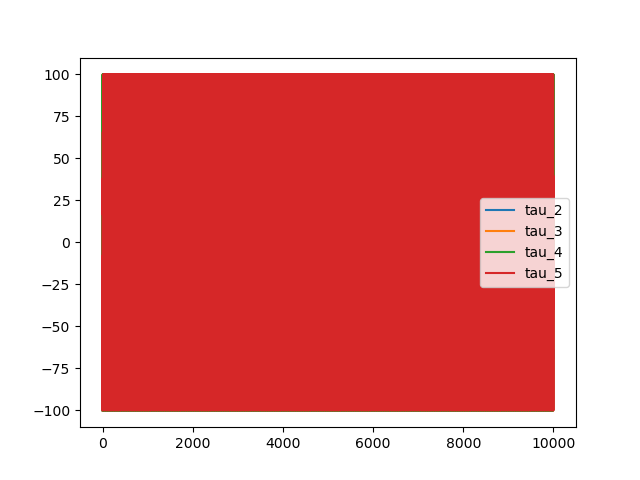

<IPython.core.display.Javascript object>


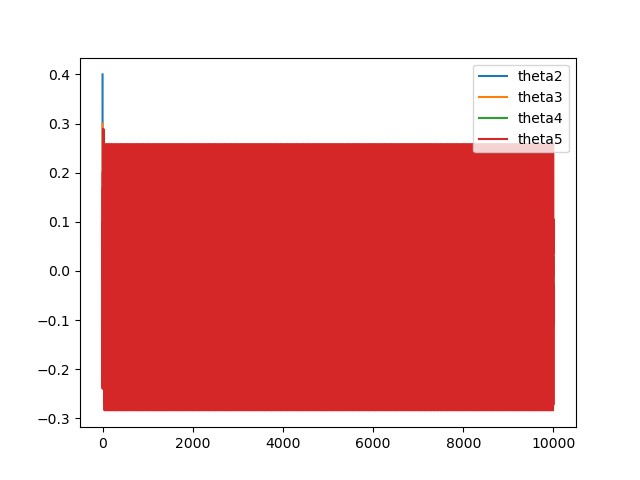

<IPython.core.display.Javascript object>


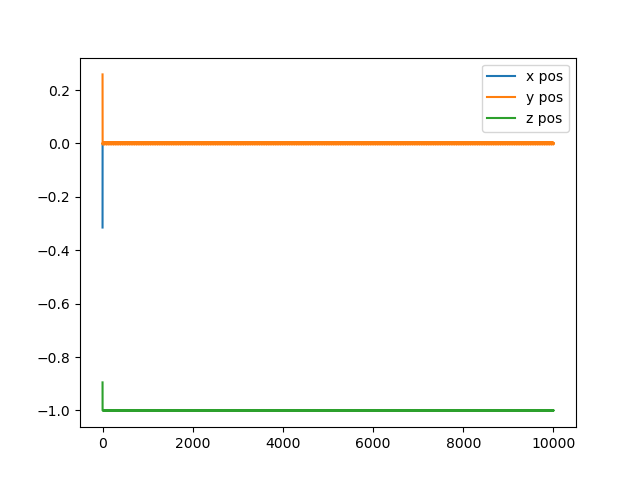

<IPython.core.display.Javascript object>


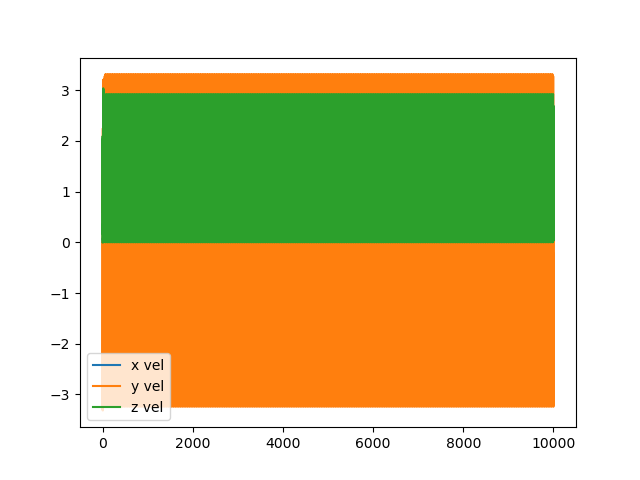

<IPython.core.display.Javascript object>


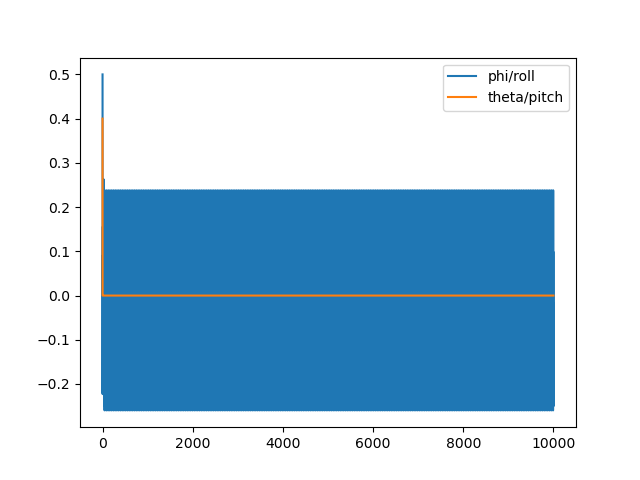

In [44]:
x_range = range(0, len(tau_setpoint_array))
#x_range = solution.t
fig = plt.figure()
ax = fig.add_subplot(111)

#ax.plot(x_range, [x[0] for x in tau_setpoint_array],label="tau_1")
ax.plot(x_range, [x[0] for x in tau_setpoint_array],label="tau_2")
ax.plot(x_range, [x[1] for x in tau_setpoint_array],label="tau_3")
ax.plot(x_range, [x[2] for x in tau_setpoint_array],label="tau_4")
ax.plot(x_range, [x[3] for x in tau_setpoint_array],label="tau_5")
plt.legend()

x_range = range(0, len(q_array))
#x_range = solution.t
fig = plt.figure()
ax = fig.add_subplot(111)

#ax.plot(x_range, [x[0] for x in q_array],label="theta1")
ax.plot(x_range, [x[0] for x in q_array],label="theta2")
ax.plot(x_range, [x[1] for x in q_array],label="theta3")
ax.plot(x_range, [x[2] for x in q_array],label="theta4")
ax.plot(x_range, [x[3] for x in q_array],label="theta5")
plt.legend()

x_range = range(0, len(p_array))

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_range, [x[0] for x in p_array],label="x pos")
ax.plot(x_range, [x[1] for x in p_array],label="y pos")
ax.plot(x_range, [x[2] for x in p_array],label="z pos")
plt.legend()

x_range = range(0, len(v_array))

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_range, [x[0] for x in v_array],label="x vel")
ax.plot(x_range, [x[1] for x in v_array],label="y vel")
ax.plot(x_range, [x[2] for x in v_array],label="z vel")
plt.legend()

x_range = range(0, len(orientation_array))

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_range, [x[0] for x in orientation_array],label="phi/roll")
ax.plot(x_range, [x[1] for x in orientation_array],label="theta/pitch")
#ax.plot(x_range, [x[2] for x in orientation_array],label="psi/yaw")

plt.legend()
plt.show()

In [45]:
print(solution.t.shape)
print(len(q_array))

(605,)
10001


In [46]:
eig_counter = 0

for i in range(len(B_array)):
    values, vectors = np.linalg.eig(B_array[i])
    #print(values)
    if any([x < 0 for x in values]) == True:
        #print("Eigenvalue is negative.")
        eig_counter += 1
        #print(B_array[i])
        
print(eig_counter, "negative eigenvalues found.")

0 negative eigenvalues found.


In [47]:
l_body_base_x, l_body_base_y, l_body_base_z = symbols("l_bb_x l_bb_y l_bb_z")

#Transformation matrix from body frame to hip base frame. 
#l_body_base is negative or positive based on which leg is described.
Hb0 = Matrix([[1, 0, 0, l_body_base_x],
              [0, 1, 0, l_body_base_y],
              [0, 0, 1, l_body_base_z],
              [0, 0, 0, 1]])

#foot_pos_base_frame = simplify(Hb0 * H01_simple * H12_simple * H23_simple * H34_simple * H45_simple * p_foot)
foot_pos_base_frame = simplify(Hb0 * H02_simple * H23_simple * H34_simple * H45_simple * p_foot)

print("Calculating foot base frame jacobian")

#J_foot_base_frame = Matrix([[simplify(diff(foot_pos_base_frame.row(0), theta1(t))), simplify(diff(foot_pos_base_frame.row(0), theta2(t))), simplify(diff(foot_pos_base_frame.row(0), theta3(t))), simplify(diff(foot_pos_base_frame.row(0), theta4(t))), simplify(diff(foot_pos_base_frame.row(0), theta5(t)))],
#                             [simplify(diff(foot_pos_base_frame.row(1), theta1(t))), simplify(diff(foot_pos_base_frame.row(1), theta2(t))), simplify(diff(foot_pos_base_frame.row(1), theta3(t))), simplify(diff(foot_pos_base_frame.row(1), theta4(t))), simplify(diff(foot_pos_base_frame.row(1), theta5(t)))],
#                             [simplify(diff(foot_pos_base_frame.row(2), theta1(t))), simplify(diff(foot_pos_base_frame.row(2), theta2(t))), simplify(diff(foot_pos_base_frame.row(2), theta3(t))), simplify(diff(foot_pos_base_frame.row(2), theta4(t))), simplify(diff(foot_pos_base_frame.row(2), theta5(t)))]])
J_foot_base_frame = Matrix([[simplify(diff(foot_pos_base_frame.row(0), theta2(t))), simplify(diff(foot_pos_base_frame.row(0), theta3(t))), simplify(diff(foot_pos_base_frame.row(0), theta4(t))), simplify(diff(foot_pos_base_frame.row(0), theta5(t)))],
                             [simplify(diff(foot_pos_base_frame.row(1), theta2(t))), simplify(diff(foot_pos_base_frame.row(1), theta3(t))), simplify(diff(foot_pos_base_frame.row(1), theta4(t))), simplify(diff(foot_pos_base_frame.row(1), theta5(t)))],
                             [simplify(diff(foot_pos_base_frame.row(2), theta2(t))), simplify(diff(foot_pos_base_frame.row(2), theta3(t))), simplify(diff(foot_pos_base_frame.row(2), theta4(t))), simplify(diff(foot_pos_base_frame.row(2), theta5(t)))]])
J_foot_base_frame

Calculating foot base frame jacobian


⎡l₃ ₓ⋅sin(θ₂) - l_3_z⋅cos(θ₂) + l₄ ₓ⋅sin(θ₂) - l_4_y⋅sin(θ₃)⋅cos(θ₂) - l_4_z⋅c
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣l₃ ₓ⋅cos(θ₂) + l_3_z⋅sin(θ₂) + l₄ ₓ⋅cos(θ₂) + l_4_y⋅sin(θ₂)⋅sin(θ₃) + l_4_z⋅s

os(θ₂)⋅cos(θ₃) + l₅ ₓ⋅sin(θ₂) - l_5_y⋅sin(θ₃ + θ₄)⋅cos(θ₂) - l_5_z⋅cos(θ₃ + θ₄
                                                                              
                                              0                               
                                                                              
in(θ₂)⋅cos(θ₃) + l₅ ₓ⋅cos(θ₂) + l_5_y⋅sin(θ₃ + θ₄)⋅sin(θ₂) + l_5_z⋅sin(θ₂)⋅cos

)⋅cos(θ₂) + l₆ ₓ⋅sin(θ₂) - l_6_y⋅sin(θ₃ + θ₄ + θ₅)⋅cos(θ₂) - l_6_z⋅cos(θ₃ + θ₄
                                                                              
                                                  

In [49]:
f_x, f_y, f_z = symbols("f_x f_y f_z")
phi, theta, psi = symbols('phi theta psi')

#Rotation matrix from body frame to world frame
R_x = Matrix([[1, 0, 0],
             [0, cos(phi), -sin(phi)],
             [0, sin(phi), cos(phi)]])

R_y = Matrix([[cos(theta), 0, sin(theta)],
              [0, 1, 0],
              [-sin(theta), 0, cos(theta)]])

R_z = Matrix([[cos(psi), -sin(psi), 0],
              [sin(psi), cos(psi), 0],
              [0, 0, 1]])

#TODO: Check this
RbW = R_x * R_y * R_z
RbW = Matrix([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])

f = Matrix([f_x, f_y, f_z])
print("Calculating tau_test...")
tau_test = simplify(J_foot_base_frame.T * RbW.T * f)
print(simplify(J_foot - J_foot_base_frame))

Calculating tau_test...
Matrix([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])


In [51]:
#theta1_symbol, theta2_symbol, theta3_symbol, theta4_symbol, theta5_symbol = symbols("theta1 theta2 theta3 theta4 theta5")
theta2_symbol, theta3_symbol, theta4_symbol, theta5_symbol = symbols("theta2 theta3 theta4 theta5")
#theta1_dot_symbol, theta2_dot_symbol, theta3_dot_symbol, theta4_dot_symbol, theta5_dot_symbol = symbols("thetadot1 thetadot2 thetadot3 thetadot4 thetadot5")
theta2_dot_symbol, theta3_dot_symbol, theta4_dot_symbol, theta5_dot_symbol = symbols("thetadot2 thetadot3 thetadot4 thetadot5")

#tau_test = tau_test.subs({theta1(t):theta1_symbol, theta2(t):theta2_symbol, theta3(t):theta3_symbol, theta4(t):theta4_symbol, theta5(t):theta5_symbol, theta1_dot(t):theta1_dot_symbol, theta2_dot(t):theta2_dot_symbol, theta3_dot(t):theta3_dot_symbol, theta4_dot(t):theta4_dot_symbol, theta5_dot(t):theta5_dot_symbol})
tau_test = tau_test.subs({theta2(t):theta2_symbol, theta3(t):theta3_symbol, theta4(t):theta4_symbol, theta5(t):theta5_symbol, theta2_dot(t):theta2_dot_symbol, theta3_dot(t):theta3_dot_symbol, theta4_dot(t):theta4_dot_symbol, theta5_dot(t):theta5_dot_symbol})
#tau_test = tau_test.subs({l1_x:l1_x_val, l2_x:l2_x_val, l3_x:l3_x_val, l4_x:l4_x_val, l5_x:l5_x_val, l6_x:l6_x_val, l1_y:l1_y_val, l2_y:l2_y_val, l3_y:l3_y_val, l4_y:l4_y_val, l5_y:l5_y_val, l6_y:l6_y_val})
#tau_test = tau_test.subs({l1_x_com:l1_x_com_val, l2_x_com:l2_x_com_val, l3_x_com:l3_x_com_val, l4_x_com:l4_x_com_val, l5_x_com:l5_x_com_val, l6_x_com:l6_x_com_val})
#tau_test = tau_test.subs({l1_y_com:l1_y_com_val, l2_y_com:l2_y_com_val, l3_y_com:l3_y_com_val, l4_y_com:l4_y_com_val, l5_y_com:l5_y_com_val, l6_y_com:l6_y_com_val})
#tau_test = tau_test.subs({l1_z:l1_z_val, l2_z:l2_z_val, l3_z:l3_z_val, l4_z:l4_z_val, l5_z:l5_z_val, l6_z:l6_z_val})
#tau_test = tau_test.subs({l1_z_com:l1_z_com_val, l2_z_com:l2_z_com_val, l3_z_com:l3_z_com_val, l4_z_com:l4_z_com_val, l5_z_com:l5_z_com_val, l6_z_com:l6_z_com_val})
#reaction_force_function = lambdify([(f_x, f_y, f_z), (theta1_symbol, theta2_symbol, theta3_symbol, theta4_symbol, theta5_symbol), (phi, theta, psi)], tau_test)
reaction_force_function = lambdify([(f_x, f_y, f_z), (theta2_symbol, theta3_symbol, theta4_symbol, theta5_symbol), (phi, theta, psi)], tau_test)

In [52]:
print(tau_test)

import symbol_replace

with open("torque_function_expr.txt", "w") as text_file:
    text_file.write(str(tau_test))

parse_for_python = False

symbol_replace.parse("torque_function_expr.txt", "torque_function_expr.txt", parse_for_python)

Matrix([[-f_x*(-l3_x*sin(theta2) + l3_z*cos(theta2) - l4_x*sin(theta2) + l4_y*sin(theta3)*cos(theta2) + l4_z*cos(theta2)*cos(theta3) - l5_x*sin(theta2) + l5_y*sin(theta3 + theta4)*cos(theta2) + l5_z*cos(theta2)*cos(theta3 + theta4) - l6_x*sin(theta2) + l6_y*sin(theta3 + theta4 + theta5)*cos(theta2) + l6_z*cos(theta2)*cos(theta3 + theta4 + theta5)) + f_z*(l3_x*cos(theta2) + l3_z*sin(theta2) + l4_x*cos(theta2) + l4_y*sin(theta2)*sin(theta3) + l4_z*sin(theta2)*cos(theta3) + l5_x*cos(theta2) + l5_y*sin(theta2)*sin(theta3 + theta4) + l5_z*sin(theta2)*cos(theta3 + theta4) + l6_x*cos(theta2) + l6_y*sin(theta2)*sin(theta3 + theta4 + theta5) + l6_z*sin(theta2)*cos(theta3 + theta4 + theta5))], [-f_x*(l4_y*cos(theta3) - l4_z*sin(theta3) + l5_y*cos(theta3 + theta4) - l5_z*sin(theta3 + theta4) + l6_y*cos(theta3 + theta4 + theta5) - l6_z*sin(theta3 + theta4 + theta5))*sin(theta2) + f_y*(l4_y*sin(theta3) + l4_z*cos(theta3) + l5_y*sin(theta3 + theta4) + l5_z*cos(theta3 + theta4) + l6_y*sin(theta3 + th